[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)



# 动态断点（Dynamic breakpoints）

## 评论（Review）

We discussed motivations for human-in-the-loop:

我们讨论了引入人类参与循环的动机：

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

`Approval` - 我们可以中断代理，将状态呈现给用户，并允许用户接受某个操作

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(2) `Debugging` - 我们可以回退图形以重现或避免问题

(3) `Editing` - You can modify the state 

(3) `Editing` - 您可以修改状态

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like `Approval`

我们介绍了断点作为一种在特定步骤停止图的通用方法，这使得像 `Approval` 这样的用例成为可能。

We also showed how to edit graph state, and introduce human feedback. 

我们还展示了如何编辑图状态，并引入人类反馈。

## 目标（Goals）

Breakpoints are set by the developer on a specific node during graph compilation. 

开发者在图编译期间在特定节点上设置断点。

But, sometimes it is helpful to allow the graph **dynamically interrupt** itself!

但是，有时允许图表 **动态中断** 自身是有帮助的！

This is an internal breakpoint, and [can be achieved using PROTECTED$15$](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

这是一个内部断点，且 [can be achieved using PROTECTED$15$](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

这有几个具体的好处：

(1) you can do it conditionally (from inside a node based on developer-defined logic).

你可以根据条件来实现它（从节点内部基于开发人员定义的逻辑）。

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `NodeInterrupt`).

(2) 您可以向用户说明其中断原因（通过将您想传递的内容发送到 `NodeInterrupt`）。

Let's create a graph where a `NodeInterrupt` is thrown based upon length of the input.

让我们创建一个图表，其中根据输入的长度会抛出一个 `NodeInterrupt`。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

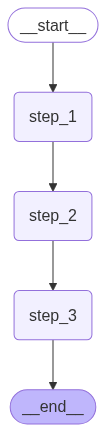

In [1]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # 如果输入字符串长度超过5个字符，我们可以选择抛出NodeInterrupt异常
    if len(state['input']) > 5:
        raise NodeInterrupt(f"收到长度超过5个字符的输入: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with an input that's longer than 5 characters. 

让我们运行一个输入超过5个字符的图。



In [2]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


If we inspect the graph state at this point, we the node set to execute next (`step_2`).


如果我们在此时检查图形状态，我们会看到接下来要执行的节点集 (`step_2`)。



In [3]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that the `Interrupt` is logged to state.

我们可以看到 `Interrupt` 已记录到状态。



In [4]:
print(state.tasks)

(PregelTask(id='69ed9fed-119e-088f-40c2-ef2f64e255f0', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='收到长度超过5个字符的输入: hello world', resumable=False, ns=None),), state=None, result=None),)


We can try to resume the graph from the breakpoint. 

我们可以尝试从断点恢复图。

But, this just re-runs the same node! 

但是，这只会重新运行相同的节点！

Unless state is changed we will be stuck here.

除非状态发生变化，否则我们将一直卡在这里。



In [5]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


In [6]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Now, we can update state.

现在，我们可以更新状态。



In [7]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a434-06cf-6f1e-8002-0ea6dc69e075'}}

In [8]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


### Usage with LangGraph API
**⚠️ DISCLAIMER**

**⚠️ 免责声明**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

自从这些视频的拍摄以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中所示使用桌面应用程序）。请参阅有关 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 本地开发服务器的文档和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录中，在终端运行以下命令：

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

你应该看到以下输出：  
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。



In [1]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

We connect to it via the SDK.

我们通过 SDK 连接到它。



In [2]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [12]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef6a43a-1b04-64d0-9a79-1caff72c8a89'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}





In [13]:
current_state = await client.threads.get_state(thread['thread_id'])

In [14]:
current_state['next']

['step_2']

In [15]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'configurable': {'thread_id': 'ea8c2912-987e-49d9-b890-6e81d46065f9',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968'},
 'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968'}

In [23]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef64c33-fb34-6eaf-8b59-1d85c5b8acc9'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [16]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': ['step_2'],
 'tasks': [{'id': '858e41b2-6501-585c-9bca-55c1e729ef91',
   'name': 'step_2',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 2,
  'source': 'update',
  'writes': {'step_1': {'input': 'hi!'}},
  'parents': {},
  'graph_id': 'dynamic_breakpoints'},
 'created_at': '2024-09-03T22:27:05.707260+00:00',
 'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968',
 'parent_checkpoint_id': '1ef6a43a-1cb8-6c3d-8001-7b11d0d34f00'}